In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
import re as re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



from sklearn.multiclass import  OneVsRestClassifier

from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import Pipeline
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
import gc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')


In [2]:
def reduce_mem(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# Loading all "csv" files.
# I named the dataframe as per the orginal name associated with "CSV" files.
framenames =[]
varsname =[]
for file in os.listdir("DataSet"):    
    if file.endswith(".csv"):
        filepath = os.path.join("DataSet", file)
        name = [i.split(".") for i in file.split("_")]
        name = reduce(lambda x, y: x + y ,name)[:-1]
        name = "_".join(name)
        vars()[name] = pd.read_csv(filepath, encoding = 'unicode_escape')
        print(name)
        framenames.append(name)
        varsname.append(vars()[name])

application_test
HomeCredit_columns_description
POS_CASH_balance
credit_card_balance
installments_payments
application_train
bureau
previous_application
bureau_balance
sample_submission


In [4]:
# applying the reduce_mem function
test = reduce_mem(application_test)
HomeCredit_columns_description = reduce_mem(HomeCredit_columns_description )
POS_CASH_balance = reduce_mem(POS_CASH_balance)
credit_card_balance = reduce_mem(credit_card_balance)
installments_payments = reduce_mem(installments_payments)
train = reduce_mem(application_train)
bureau= reduce_mem(bureau)
previous_application = reduce_mem(previous_application )
bureau_balance = reduce_mem(bureau_balance)

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 14.9%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


In [5]:
# deleting the unused file from the memory
del application_test, application_train


In [6]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [9]:
# creating a column whose values are number of previous loans in the bureau.
loan_counts_previous = bureau.groupby("SK_ID_CURR", as_index = False)["SK_ID_BUREAU"].count().rename(
    columns = {"SK_ID_BUREAU":"LOAN_COUNTS_BUREAU"})
loan_counts_previous.head()

,SK_ID_CURR,LOAN_COUNTS_BUREAU
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [10]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Integrate the number of previous loan to the train dataframe
train = pd.merge(train, loan_counts_previous,how ="left", on ="SK_ID_CURR")
# filling the missing values by zero
train['LOAN_COUNTS_BUREAU']= train["LOAN_COUNTS_BUREAU"].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,LOAN_COUNTS_BUREAU
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
# Extracting the SK_ID_CURR and TARGET columns as a dataframe
train_id = train[["SK_ID_CURR","TARGET"]]
test_id = test[["SK_ID_CURR"]]

# Extracting only relevant observations from the bureau as well as adding the TARGET column to the bureau_train
bureau_train = pd.merge(train_id, bureau,how ="left", on ="SK_ID_CURR")
bureau_test  = pd.merge(test_id, bureau, how="left", on = "SK_ID_CURR")

#Checking if the bureau contains all of the train and test observations.
print("The total number of observations in the bureau_train ({}) and bureau_test ({}) matches with that for the train ({}) and the test ({}).".format(bureau_train .groupby("SK_ID_CURR").sum().shape[0],
                                                                                                                                             bureau_test.groupby("SK_ID_CURR").sum().shape[0],
                                                                                                                                             train.shape[0], test.shape[0]))


The total number of observations in the bureau_train (307511) and bureau_test (48744) matches with that for the train (307511) and the test (48744).


I am building a custom function so that after grouping by the SK_ID_CURR, that agg function when applied on the TARGET column, will preserve the correct architecture of the TARGET column.  I am aggregating the TARGET column both sum and custom_sum function, so I can compare if my custome_function is doing its intended job! Later I will check if the added SK_ID_CURR and TARGET columns preserved their structures and identities in the bureau dataframe, named bureau_train, during extraction and addition. 

In [9]:
def custom_sum(series):
       return reduce(lambda x, y: x, series)
bureau_train_id_target = bureau_train.groupby("SK_ID_CURR").agg({"TARGET": custom_sum}).reset_index()
bureau_train_id_target.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [10]:
# With a control aggreation function (sum)
bureau_train.groupby("SK_ID_CURR").agg({"TARGET": ["sum", custom_sum]}).reset_index().head()


SK_ID_CURR TARGET           
                sum custom_sum
0     100002      8          1
1     100003      0          0
2     100004      0          0
3     100006      0          0
4     100007      0          0

In [11]:
#I am checking if merging preserved the correct SK_ID_CURR and the corresponding TARGET values
assert (train["SK_ID_CURR"].tolist()== bureau_train_id_target["SK_ID_CURR"].tolist()), " It was not okay "
assert (train["TARGET"].tolist()== bureau_train_id_target["TARGET"].tolist()), " It was not okay "
# It didn't raise any assertion error, which suggests our transfer from the train data bureau_train were okay. 


In [12]:
# Additional control for our assert statment
assert (len(train[["SK_ID_CURR", "TARGET"]]) ==len(bureau_train_id_target[["SK_ID_CURR", "TARGET"]])), "Length of train_bureau and bureau are expected not to be the same."
assert (train.shape[0]== bureau_train.shape[0]), "Shape of train_bureau and bureau are expected not to be the same"
# Raised an assertion error which is expected. 

AssertionError: Shape of train_bureau and bureau are expected not to be the same

In [13]:
# Extracting all object columns from bureau
bureau_object_cols = bureau_train.select_dtypes("object").columns.tolist()
bureau_object_cols

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [14]:
# Exploring the composition of all object columns
for col in bureau_object_cols:
    print(bureau_train[col].value_counts())

Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
currency 1    1464094
currency 2       1072
currency 3        150
currency 4          9
Name: CREDIT_CURRENCY, dtype: int64
Consumer credit                                 1069610
Credit card                                      343853
Car loan                                          23757
Mortgage                                          15607
Microloan                                          9005
Loan for business development                      1721
Another type of loan                                854
Unknown type of loan                                472
Loan for working capital replenishment              377
Cash loan (non-earmarked)                            23
Real estate loan                                     23
Loan for the purchase of equipment                   17
Loan for purchase of shares (margin lending)          4
Mobile operator loan                  

In [27]:
def kdeplot(df, feature_list = None, plot_style = 'ggplot' ): 
    plt.style.use(plot_style)
    plt.figure(figsize =(8,18))
    for idx, ft in enumerate(feature_list):
        plt.subplot(len(feature_list),1, idx+1)

        sns.kdeplot(df.loc[df["TARGET"]==1, ft], shade =True, cut =0, label ="Defaulted Client (1)")
        
        sns.kdeplot(df.loc[df["TARGET"]==0, ft], shade =True, cut =0, label ="Good Client (0)")
        
        one = (df.loc[df["TARGET"]==1, ft]).max()
        zero = (df.loc[df["TARGET"]==0, ft]).max()
        ymax = max(one,zero)
        #plt.ylim(0,ymax)
        plt.title("Distribution of {} ".format(ft))
        plt.xlabel("{}".format(ft))
        plt.ylabel("Distributions")


    plt.tight_layout(pad=1.8,h_pad = 2.5, rect =(0,0,1,1))


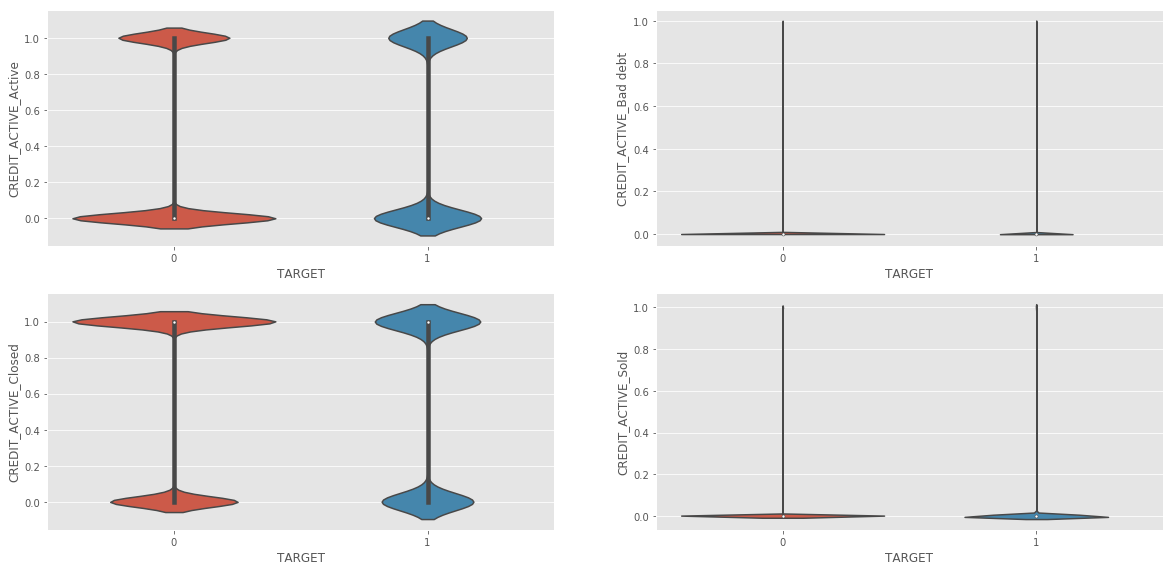

In [40]:
def violinplot(df, cols):
    """
    This will plot both violin and box plot on top of each othere for 
    each features, which would be better to understand the data,
    for the categories of the target variable.
    The dataframe has to contain 40 features to use this function.
    """
    
    plt.figure(figsize =(20,20))
    for idx, ft in enumerate(cols):
        plt.subplot(len(cols),2, idx+1)
        sns.violinplot(y=df[ft], x=df["TARGET"])
        #sns.boxplot(y=df[ft], x=df["TARGET"])

feature_list =credit_active.columns.tolist()[2:]
violinplot(credit_active, feature_list)


In [ ]:
sns.violinplot()

In [41]:
# Exploring the column the credit_active column and its relationship with the target column
bureau_credit_active = bureau_train.groupby("SK_ID_CURR")["CREDIT_ACTIVE"].count().reset_index()
#Extracting the target column as a dataframe
target = train[["SK_ID_CURR","TARGET"]]
# Adding the target colun to the bureau_credit_active
bureau_credit_active = pd.merge(bureau_credit_active,target, how ="left" , on = "SK_ID_CURR")
# Visualizing the corrlation between the number of accounts active under credit_active and target feature.
bureau_credit_active.head()

,SK_ID_CURR,CREDIT_ACTIVE,TARGET
0,100002,8,1
1,100003,4,0
2,100004,2,0
3,100006,0,0
4,100007,1,0


In [42]:
# Here I am grouping by the number of CREDIT_ACTIVE and aggregating target columns by count and sum.
# The count column tells us how many observations for a particular credit type
# getting dummies for the object column CREDIT_Active
credit_active = pd.get_dummies(bureau_train[["SK_ID_CURR","CREDIT_ACTIVE", "TARGET"]])
credit_active.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold']

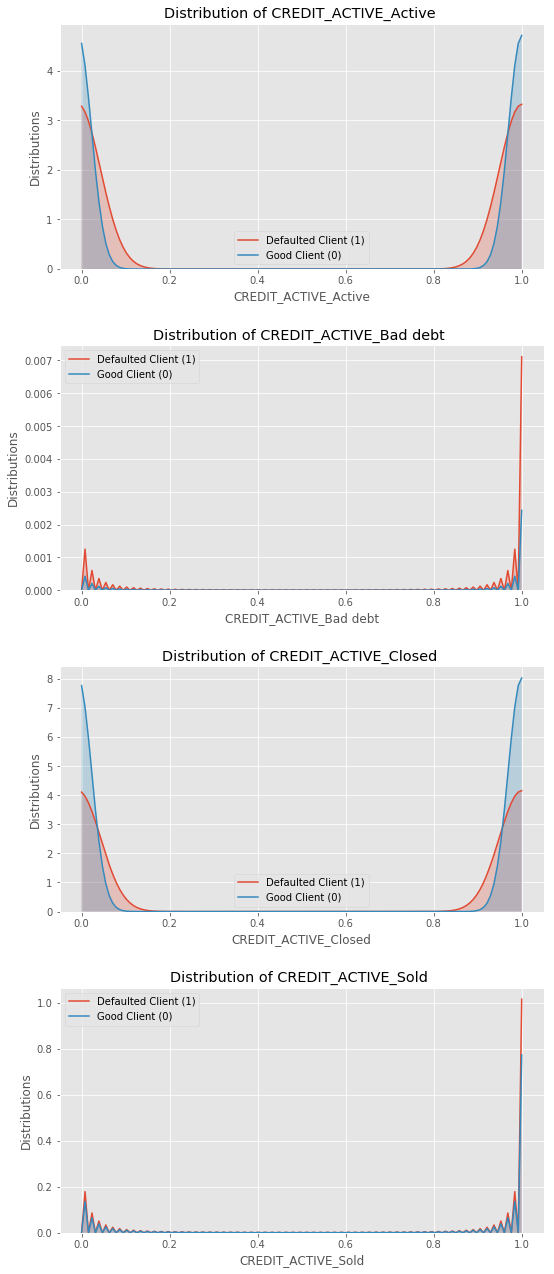

In [37]:
kdeplot(credit_active, feature_list =credit_active.columns.tolist()[2:])

In [17]:

def custom_sum(series):
       return reduce(lambda x, y: x, series)
# Now grouping by SK_ID_CURR
credit_active_sum = credit_active.groupby("SK_ID_CURR").agg({
    "TARGET":custom_sum,
    "CREDIT_ACTIVE_Active":"sum",
    "CREDIT_ACTIVE_Closed":"sum",
    "CREDIT_ACTIVE_Sold":"sum",
    "CREDIT_ACTIVE_Sold":"sum"})
credit_active_sum.head()

,TARGET,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold
SK_ID_CURR,,,,
100002,1,2,6,0
100003,0,1,3,0
100004,0,0,2,0
100006,0,0,0,0
100007,0,0,1,0


In [100]:
exercise = sns.load_dataset("exercise")
exercise.pulse.nunique()

39

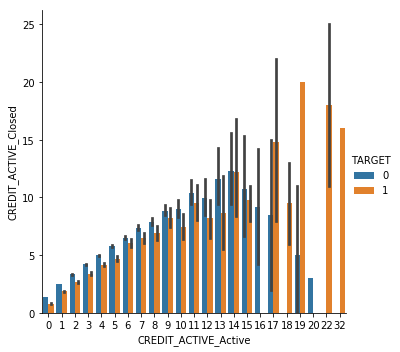

In [31]:
g = sns.catplot(x ="CREDIT_ACTIVE_Active", y ="CREDIT_ACTIVE_Closed", hue ="TARGET",
                data=credit_active_sum,
                kind="bar")

In [52]:
bureau_train.columns

Index(['SK_ID_CURR', 'TARGET', 'SK_ID_BUREAU', 'CREDIT_ACTIVE',
       'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'],
      dtype='object')

In [53]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [55]:
credit_card_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3090496.0,3.840312e+06,3.090496e+06,3090496.0,3535076.0,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.827686e+04,1.538080e+05,5.962299e+03,7.432263e+03,2.881647e+02,2.968840e+03,3.541778e+03,...,5.595036e+04,5.808502e+04,5.809459e+04,NaN,7.031439e-01,4.810333e-03,NaN,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.074641e+05,1.651457e+05,2.803397e+04,3.336682e+04,8.197021e+03,2.066321e+04,5.525350e+03,...,1.015177e+05,1.071769e+05,1.071802e+05,0.0,3.190347e+00,8.239746e-02,0.0,0.0,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,4.0,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,15.0,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.0,0.000000e+00,0.000000e+00,0.0,32.0,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,51.0,1.650000e+02,1.200000e+01,165.0,120.0,3.260000e+03,3.260000e+03


In [44]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [45]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [46]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int32
SK_ID_CURR                    int32
MONTHS_BALANCE                int8
AMT_BALANCE                   float32
AMT_CREDIT_LIMIT_ACTUAL       int32
AMT_DRAWINGS_ATM_CURRENT      float32
AMT_DRAWINGS_CURRENT          float32
AMT_DRAWINGS_OTHER_CURRENT    float32
AMT_DRAWINGS_POS_CURRENT      float32
AMT_INST_MIN_REGULARITY       float32
AMT_PAYMENT_CURRENT           float32
AMT_PAYMENT_TOTAL_CURRENT     float32
AMT_RECEIVABLE_PRINCIPAL      float32
AMT_RECIVABLE                 float32
AMT_TOTAL_RECEIVABLE          float32
CNT_DRAWINGS_ATM_CURRENT      float16
CNT_DRAWINGS_CURRENT          int16
CNT_DRAWINGS_OTHER_CURRENT    float16
CNT_DRAWINGS_POS_CURRENT      float16
CNT_INSTALMENT_MATURE_CUM     float16
NAME_CONTRACT_STATUS          object
SK_DPD                        int16
SK_DPD_DEF                    int16
dtypes: float16(4), float32(1

In [47]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [49]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int32
SK_ID_CURR                int32
NUM_INSTALMENT_VERSION    float16
NUM_INSTALMENT_NUMBER     int16
DAYS_INSTALMENT           float16
DAYS_ENTRY_PAYMENT        float16
AMT_INSTALMENT            float32
AMT_PAYMENT               float32
dtypes: float16(3), float32(2), int16(1), int32(2)
memory usage: 311.4 MB


In [88]:
# Extracting the SK_ID_CURR and TARGET columns as a dataframe
train_id = train[["SK_ID_CURR","TARGET"]]
test_id = test[["SK_ID_CURR"]]

# Extracting only relevant observations from the bureau as well as adding the TARGET column to the bureau_train
installments_payments_train = pd.merge(train_id, installments_payments,how ="left", on ="SK_ID_CURR")
installments_payments_test  = pd.merge(test_id, installments_payments, how="left", on = "SK_ID_CURR")

shape_installements_train = installments_payments_train .groupby("SK_ID_CURR").sum().shape[0],
shape_installments_test = installments_payments_test.groupby("SK_ID_CURR").sum().shape[0],
                                 
#Checking if the bureau contains all of the train and test observations.
if train.shape[0] == shape_installements_train and shape_installments_test ==test.shape[0]:
    print("The total number of observations in the new_train and new_test matches with that for the train and the test.")


In [12]:
import featuretools as ft

In [31]:
class aggregator(object):
    
    def __int__(self):
        pass
    
    def numeric_aggregation(self, df,
                            groupby_variable ="SK_ID_CURR",
                            aggregation_functions = ["mean", "max", "min", "sum", "std","count","prod", "var" ],
                            df_name = "Bu"):
        """
        Parameters:
        -----------
        df (DataFrame): the dataframe to perform numeric aggregation on.
        groupby_variable: the variable that will be used to aggregate.
        aggregation_functions: the functions that will be used for aggregations.
        
        """
        
        # Removing id variables other than grouping variable
        for column in df:
            if column != groupby_variable and "SK_ID" in column:
                df = df.drop(columns = column, axis =1)
                
        ids = df[groupby_variable]
        numeric_df = df.select_dtypes("number")
        numeric_df[groupby_variable] =ids
        
        # Grouping by groupby_variable and aggregating using the list of functions in aggregation_functions
        aggregated_df = numeric_df.groupby(groupby_variable).agg(aggregation_functions).reset_index()
        
        
        columns =[groupby_variable]
        # Rename the column names after the dataframe
        
        for column in aggregated_df.columns.levels[0]:
            if column != groupby_variable:
                for estimator in aggregated_df.columns.levels[1][:-1]:
                    columns.append("%s_%s_%s" % (vars()[df], columns, estimator))
                    
        aggregated_df.columns = columns
        return aggregated_df
        
agg = aggregator()       

In [32]:
agg.numeric_aggregation(bureau)

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [22]:
for col in bureau:
    print(col)

SK_ID_CURR
SK_ID_BUREAU
CREDIT_ACTIVE
CREDIT_CURRENCY
DAYS_CREDIT
CREDIT_DAY_OVERDUE
DAYS_CREDIT_ENDDATE
DAYS_ENDDATE_FACT
AMT_CREDIT_MAX_OVERDUE
CNT_CREDIT_PROLONG
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE
CREDIT_TYPE
DAYS_CREDIT_UPDATE
AMT_ANNUITY
